# Machine Translation: English-French Europarl

This notebook implements three translation approaches:
1. **Baseline**: Word-for-word translation using a bilingual dictionary
2. **Advanced**: Cross-lingual embeddings for semantic translation
3. **Best Model**: Fine-tuned Seq2Seq Transformer (iterative improvement)

We'll evaluate all models on a train/test split of the Europarl corpus.

In [1]:
import sys
import subprocess

required_libraries = [
    "numpy",
    "scikit-learn",         
    "nltk",
    "sentence-transformers",
    "transformers",
    "datasets",
    "accelerate>=0.26.0",   
    "sentencepiece",
    "packaging",
    "torch"
]
try:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install'] + required_libraries)
    print("All libraries installed successfully!")
except subprocess.CalledProcessError as e:
    print(f"Installation failed. Error: {e}")

All libraries installed successfully!



# 1. Data loading

In [2]:
from pathlib import Path
from collections import defaultdict
import re
import pandas as pd

# 1. Setup Paths
NOTEBOOK_DIR = Path.cwd()
DATA_DIR = NOTEBOOK_DIR / "data"

# Define the specific files you have
EN_PATH = DATA_DIR / "Europarl.en-fr.en"
FR_PATH = DATA_DIR / "Europarl.en-fr.fr"

# Verify they exist
if EN_PATH.exists() and FR_PATH.exists():
    print(f"Found English file: {EN_PATH.name}")
    print(f"Found French file:  {FR_PATH.name}")
else:
    print("Error: Files not found. Check your folder structure.")

def load_parallel_subset(en_path, fr_path, max_lines):
    """
    Reads two aligned text files and returns a Pandas DataFrame with columns ['en', 'fr'].
    """
    pairs = []
    
    try:
        # Open both files at the same time
        with open(en_path, "r", encoding="utf-8") as f_en, \
             open(fr_path, "r", encoding="utf-8") as f_fr:
            
            # zip() pairs lines together safely
            for i, (line_en, line_fr) in enumerate(zip(f_en, f_fr)):
                if i >= max_lines:
                    break
                
                text_en = line_en.strip()
                text_fr = line_fr.strip()
                
                # Only keep if both sides have content
                if text_en and text_fr:
                    pairs.append((text_en, text_fr))
                    
    except Exception as e:
        print(f"Error reading files: {e}")
        return pd.DataFrame()  # Return empty DF on error

    # Convert list of tuples to DataFrame
    df = pd.DataFrame(pairs, columns=["en", "fr"])
    return df

Found English file: Europarl.en-fr.en
Found French file:  Europarl.en-fr.fr


In [3]:
subset_size = 100000

# Run the loader
df = load_parallel_subset(EN_PATH, FR_PATH, max_lines=subset_size)
print(f"Successfully loaded {len(df)} pairs.")

Successfully loaded 100000 pairs.


In [4]:
# Run the new loader
df = load_parallel_subset(EN_PATH, FR_PATH, max_lines=subset_size)

# Convert back to list of tuples for your old analysis functions
pairs = df.to_records(index=False).tolist()

print(f"DataFrame shape: {df.shape}")
print(f"Pairs list length: {len(pairs)}")

DataFrame shape: (100000, 2)
Pairs list length: 100000


In [ ]:
from sklearn.model_selection import train_test_split

# Split into train/test/val (80/10/10) sets
train_val_pairs, test_pairs = train_test_split(
    pairs,
    test_size=0.1,      # 10% test
    random_state=42,
    shuffle=True
)

train_pairs, val_pairs = train_test_split(
    train_val_pairs,
    test_size=0.1111,   # 10 / 90 = 0.1111 (approx.)
    random_state=42,
    shuffle=True
)


train_pairs[:6]

[('I am proud of the fact that the European Parliament is making such an important contribution to this.',
  'Je suis fier que le Parlement européen y contribue de la sorte.'),
 ('We must be more vigorous about the process of European integration and must not begin to be in two minds about it.',
  "Nous devons investir plus d'énergie dans le processus d'intégration européenne, et non pas commencer à douter."),
 ('As you can see, we have not let the grass grow under our feet.',
  "Comme vous le voyez, nous n' avons pas perdu de temps."),
 ('I would like to address a big thank you to the Ombudsman and his office, as well as to the secretariat at the Committee on Petitions which, as we know, is currently working under difficult conditions.',
  "Je voudrais adresser un grand merci au médiateur et à son cabinet, ainsi qu'au secrétariat de la commission des pétitions, qui, nous le savons aujourd'hui, travaille dans des conditions difficiles."),
 ('The common position offers an adequate level

# 2. Models 

## 2.1 Baseline: Word-for-Word Translation

This baseline model builds a bilingual dictionary from the training data and translates each word independently.

In [6]:
class WordForWordTranslator:
    """Baseline word-for-word translation using bilingual dictionary."""
    
    def __init__(self):
        self.word_dict = defaultdict(lambda: defaultdict(int))
        self.most_common_translations = {}
        
    def train(self, train_pairs):
        """Build bilingual dictionary from training pairs."""
        print("Building bilingual dictionary...")
        
        for en_text, fr_text in train_pairs:
            # Simple tokenization (split on whitespace and punctuation)
            en_words = re.findall(r'\b\w+\b', en_text.lower())
            fr_words = re.findall(r'\b\w+\b', fr_text.lower())
            
            if not en_words or not fr_words:
                continue
            
            # Use positional alignment based on relative position
            # This prevents common words like "de" from dominating
            en_len = len(en_words)
            fr_len = len(fr_words)
            
            # Align words based on their relative positions
            for i, en_word in enumerate(en_words):
                # Map English position to French position
                fr_pos = int((i / en_len) * fr_len)
                fr_pos = min(fr_pos, fr_len - 1)  # Ensure valid index
                
                # Align to the word at the corresponding position
                fr_word = fr_words[fr_pos]
                self.word_dict[en_word][fr_word] += 1
                
                # Also align to nearby words (within 1 position) for better coverage
                if fr_pos > 0:
                    self.word_dict[en_word][fr_words[fr_pos - 1]] += 0.5
                if fr_pos < fr_len - 1:
                    self.word_dict[en_word][fr_words[fr_pos + 1]] += 0.5
        
        # Store most common translation for each English word
        for en_word, fr_translations in self.word_dict.items():
            if fr_translations:
                self.most_common_translations[en_word] = max(
                    fr_translations.items(), 
                    key=lambda x: x[1]
                )[0]
        
        print(f"Dictionary built with {len(self.most_common_translations):,} English words")
        
    def translate(self, en_text):
        """Translate English text word-by-word."""
        en_words = re.findall(r'\b\w+\b', en_text)
        fr_words = []
        
        for word in en_words:
            word_lower = word.lower()
            if word_lower in self.most_common_translations:
                fr_words.append(self.most_common_translations[word_lower])
            else:
                # Unknown word - keep original
                fr_words.append(word)
        
        return ' '.join(fr_words)
    
    def translate_preserve_case(self, en_text):
        """Translate preserving original word casing."""
        en_words = re.findall(r'\b\w+\b', en_text)
        fr_words = []
        
        for word in en_words:
            word_lower = word.lower()
            if word_lower in self.most_common_translations:
                translation = self.most_common_translations[word_lower]
                # Preserve case
                if word[0].isupper():
                    translation = translation.capitalize()
                fr_words.append(translation)
            else:
                fr_words.append(word)
        
        return ' '.join(fr_words)

In [7]:
# Train the baseline model
baseline_model = WordForWordTranslator()
baseline_model.train(train_pairs)

Building bilingual dictionary...
Dictionary built with 25,140 English words


## 2.2 Advanced Model: Cross-Lingual Embeddings

This model uses pre-trained multilingual embeddings to find the best translation by comparing semantic similarity.

In [9]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

class CrossLingualEmbeddingTranslator:
    """Translation using cross-lingual embeddings and semantic similarity."""
    
    def __init__(self, model_name='paraphrase-multilingual-MiniLM-L12-v2'):
        """
        Initialize with a multilingual sentence transformer.
        Options:
        - 'paraphrase-multilingual-MiniLM-L12-v2' (fast, good quality)
        - 'paraphrase-multilingual-mpnet-base-v2' (slower, better quality)
        - 'distiluse-base-multilingual-cased' (alternative)
        """
        print(f"Loading multilingual embedding model: {model_name}...")
        self.model = SentenceTransformer(model_name)
        self.french_candidates = []
        self.french_embeddings = None
        
    def train(self, train_pairs):
        """Build a candidate pool of French translations from training data."""
        print("Building French candidate pool...")
        
        # Collect unique French sentences (or a large sample)
        french_sentences = set()
        for _, fr_text in train_pairs:
            if fr_text.strip():
                french_sentences.add(fr_text.strip())
        
        # Limit to reasonable size for efficiency (can be adjusted)
        max_candidates = 50000
        if len(french_sentences) > max_candidates:
            french_sentences = list(french_sentences)[:max_candidates]
        else:
            french_sentences = list(french_sentences)
        
        self.french_candidates = french_sentences
        
        # Pre-compute embeddings for all French candidates
        print(f"Computing embeddings for {len(self.french_candidates):,} French candidates...")
        self.french_embeddings = self.model.encode(
            self.french_candidates,
            show_progress_bar=True,
            batch_size=32
        )
        print("Training complete!")
        
    def translate(self, en_text, top_k=1):
        """
        Translate by finding the most semantically similar French sentence.
        
        Args:
            en_text: English text to translate
            top_k: Number of top candidates to return (default: 1, returns best match)
        """
        if not en_text.strip():
            return ""
        
        # Get embedding for English text
        en_embedding = self.model.encode([en_text])
        
        # Compute cosine similarity with all French candidates
        similarities = cosine_similarity(en_embedding, self.french_embeddings)[0]
        
        # Get top-k most similar
        top_indices = np.argsort(similarities)[-top_k:][::-1]
        
        if top_k == 1:
            return self.french_candidates[top_indices[0]]
        else:
            return [self.french_candidates[idx] for idx in top_indices]

/home/mhayakawa/miniconda3/envs/rocm_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
# Train the cross-lingual embedding model
print("Training cross-lingual embedding model...")
embedding_model = CrossLingualEmbeddingTranslator()
embedding_model.train(train_pairs)

Training cross-lingual embedding model...
Loading multilingual embedding model: paraphrase-multilingual-MiniLM-L12-v2...


Loading weights: 100%|██████████| 199/199 [00:00<00:00, 1623.63it/s, Materializing param=pooler.dense.weight]                               
BertModel LOAD REPORT from: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Building French candidate pool...
Computing embeddings for 50,000 French candidates...


Batches: 100%|██████████| 1563/1563 [00:50<00:00, 30.72it/s] 

Training complete!


## 2.3 Best Model: Fine-tuned Seq2Seq Transformer

This is our iterative improvement model. We'll fine-tune a pretrained transformer model on our Europarl data to achieve the best translation quality.

In [15]:
import json
import torch
import itertools
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq
)

# Set device (CUDA, Apple Silicon MPS, or CPU)
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using device: {device}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = torch.device("mps")
    print(f"Using device: {device} (Apple Silicon GPU)")
else:
    device = torch.device("cpu")
    print(f"Using device: {device} (CPU)")

Using device: cuda
GPU: AMD Radeon RX 9070 XT


### Model architecture: Seq2Seq Translator

In [16]:
class Seq2SeqTranslator:
    """Fine-tuned Seq2Seq Transformer for English-French translation."""
    
    def __init__(self, model_name='Helsinki-NLP/opus-mt-en-fr', max_length=128):
        self.model_name = model_name
        self.max_length = max_length
        self.device = device
        
        print(f"Initializing model: {model_name}...")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
        self.model.to(self.device)
        
    def train(self, train_pairs, val_pairs=None, 
              num_epochs=3, batch_size=8, learning_rate=5e-5, 
              save_steps=1000, eval_steps=500, warmup_steps=500, 
              output_dir=None, **kwargs):
        """
        **kwargs captures: weight_decay, label_smoothing_factor, fp16, etc.
        from your grid search.
        """
        
        # 1. Prepare Data
        if val_pairs is None:
            val_size = max(1, len(train_pairs) // 10)
            val_pairs = train_pairs[:val_size]
            train_pairs = train_pairs[val_size:]
            
        def prepare_dataset(pairs):
            return Dataset.from_dict({'en': [p[0] for p in pairs], 'fr': [p[1] for p in pairs]})
            
        train_dataset = prepare_dataset(train_pairs)
        val_dataset = prepare_dataset(val_pairs)
        
        # 2. Tokenize
        def tokenize_function(examples):
            model_inputs = self.tokenizer(examples['en'], max_length=self.max_length, truncation=True, padding='max_length')
            labels = self.tokenizer(text_target=examples['fr'], max_length=self.max_length, truncation=True, padding='max_length')
            model_inputs['labels'] = [
                [(l if l != self.tokenizer.pad_token_id else -100) for l in label]
                for label in labels['input_ids']
            ]
            return model_inputs
            
        train_dataset = train_dataset.map(tokenize_function, batched=True, remove_columns=['en', 'fr'])
        val_dataset = val_dataset.map(tokenize_function, batched=True, remove_columns=['en', 'fr'])
        
        data_collator = DataCollatorForSeq2Seq(tokenizer=self.tokenizer, model=self.model, padding=True)
        
        # 3. Setup Arguments (Integrating your specific params)
        if output_dir is None:
            output_dir = f"./seq2seq_model_{self.model_name.split('/')[-1]}"
            
        training_args = Seq2SeqTrainingArguments(
            output_dir=output_dir,
            num_train_epochs=num_epochs,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            learning_rate=learning_rate,
            warmup_steps=warmup_steps,
            logging_dir=f'{output_dir}/logs',
            logging_steps=100,
            eval_steps=eval_steps,
            save_steps=save_steps,
            eval_strategy="steps",
            save_total_limit=2,
            load_best_model_at_end=True,
            metric_for_best_model="eval_loss",
            greater_is_better=False,
            report_to="none",
            # Defaults that can be overridden by **kwargs
            fp16=kwargs.get('fp16', (device == "cuda")), 
            weight_decay=kwargs.get('weight_decay', 0.01),
            label_smoothing_factor=kwargs.get('label_smoothing', 0.0)
        )
        
        trainer = Seq2SeqTrainer(
            model=self.model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            data_collator=data_collator,
            processing_class=self.tokenizer,
        )
        
        print(f"Starting training on {len(train_pairs)} examples...")
        trainer.train()
        
        # Save
        trainer.save_model()
        self.tokenizer.save_pretrained(output_dir)
        with open(os.path.join(output_dir, "training_logs.json"), "w") as f:
            json.dump(trainer.state.log_history, f)
            
        return trainer

    def translate(self, en_text, max_length=None, num_beams=4):
        if max_length is None: max_length = self.max_length
        inputs = self.tokenizer(en_text, return_tensors="pt", max_length=self.max_length, truncation=True, padding=True).to(self.device)
        with torch.no_grad():
            outputs = self.model.generate(**inputs, max_length=max_length, num_beams=num_beams, early_stopping=True)
        return self.tokenizer.decode(outputs[0], skip_special_tokens=True)

### Hyper-parameter fine-tuning of Seq2Seq

In [ ]:
def hyperparameter_grid_search(train_pairs, val_pairs):
    """
    Runs grid search using your exact parameters.
    """
    search_space = {
    "learning_rate": [2e-5, 5e-5],
    "label_smoothing": [0.0, 0.1]
    }   

    keys, values = zip(*search_space.items())
    combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
    
    print(f"Starting Grid Search with {len(combinations)} candidates...")
    
    results = []
    
    for i, config in enumerate(combinations):
        print(f"\n Experiment {i+1}/{len(combinations)} ")
        print(f"Config: {config}")
        
        # Initialize fresh model for every run
        model_wrapper = Seq2SeqTranslator(model_name='Helsinki-NLP/opus-mt-en-fr')
        
        # Train with specific config
        trainer = model_wrapper.train(
            train_pairs, 
            val_pairs,
            num_epochs=1,  # to avoid having way too long training time...
            output_dir=f"./grid_search/run_{i}",
            batch_size=32, # with 16GB VRAM should be ok 
            learning_rate=config["learning_rate"],
            weight_decay=0.01,  # standard default 
            label_smoothing=config["label_smoothing"]
        )
        
        metrics = trainer.evaluate()
        val_loss = metrics['eval_loss']

        results.append({
            "learning_rate": config["learning_rate"],
            "batch_size": 16,
            "weight_decay": 0.01,
            "label_smoothing": config["label_smoothing"],     
            "val_loss": val_loss
        })
        
        print(f"--> Validation Loss: {val_loss:.4f}")
        
    df = pd.DataFrame(results)
    best_run = df.loc[df['val_loss'].idxmin()]
    
    print("\n" + "="*30)
    print("BEST HYPERPARAMETERS FOUND")
    print("="*30)
    print(best_run)
    return best_run

In [18]:
import os

# Define where we want the model to be saved/loaded from
model_output_path = "seq2seq_model_opus-mt-en-fr"
seq2seq_model = Seq2SeqTranslator()

Initializing model: Helsinki-NLP/opus-mt-en-fr...


/home/mhayakawa/miniconda3/envs/rocm_env/lib/python3.12/site-packages/transformers/models/marian/tokenization_marian.py:176: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
Loading weights: 100%|██████████| 258/258 [00:00<00:00, 2479.47it/s, Materializing param=model.shared.weight]                                  
The tied weights mapping and config for this model specifies to tie model.shared.weight to model.decoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
The tied weights mapping and config for this model specifies to tie model.shared.weight to model.encoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


# 
### [Case A]: Model exists: RUN THIS.
# 


In [19]:
if os.path.exists(model_output_path) and os.path.isfile(os.path.join(model_output_path, "model.safetensors")):
    print(f"Found existing fine-tuned model at '{model_output_path}'. Loading...")
    
    # Reload the tokenizer and model from the saved directory
    seq2seq_model.tokenizer = AutoTokenizer.from_pretrained(model_output_path)
    seq2seq_model.model = AutoModelForSeq2SeqLM.from_pretrained(model_output_path)
    seq2seq_model.model.to(device)
    
    print("Model loaded successfully and ready for translation.")

Found existing fine-tuned model at 'seq2seq_model_opus-mt-en-fr'. Loading...


Loading weights: 100%|██████████| 256/256 [00:00<00:00, 1415.34it/s, Materializing param=model.shared.weight]                                 
The tied weights mapping and config for this model specifies to tie model.shared.weight to model.decoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
The tied weights mapping and config for this model specifies to tie model.shared.weight to model.encoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


Model loaded successfully and ready for translation.



# 
### [Case B]: Model does not exist: RUN THIS 
# 
### (GPU required for fine-tuning, recommended for simple training)

In [25]:
print(f"No model found at '{model_output_path}'. Starting training process...")

# 1. OPTIONAL: Run Grid Search to find best params
# (If you want to skip this and just train, comment these 2 lines out)
print("Step 1: Running Hyperparameter Grid Search...")

best_config = hyperparameter_grid_search(train_pairs, val_pairs)

print(f"Best config found: {best_config}")

# 2. Train the final model using the best parameters
print("Step 2: Training Final Model...")

# Determine hardware batch size defaults if grid search didn't run
if 'best_config' not in locals():
    # Fallback defaults if you skipped grid search
    best_config = {
        "batch_size": 16 if torch.cuda.is_available() else 4,
        "learning_rate": 5e-5,
        "weight_decay": 0.01,
        "label_smoothing": 0.1
    }

seq2seq_model.train(
    train_pairs,
    val_pairs,
    num_epochs=3, # Train for real now (3+ epochs)
    output_dir=model_output_path, # SAVE TO THIS PATH
    batch_size=int(best_config["batch_size"]),
    learning_rate=float(best_config["learning_rate"]),
    weight_decay=float(best_config["weight_decay"]),
    label_smoothing=float(best_config["label_smoothing"])
)

print(f"\nTraining complete! Model saved to {model_output_path}")

No model found at 'seq2seq_model_opus-mt-en-fr'. Starting training process...
Step 1: Running Hyperparameter Grid Search...
Starting Grid Search with 4 candidates...

--- Experiment 1/4 ---
Config: {'learning_rate': 2e-05, 'label_smoothing': 0.0}
Initializing model: Helsinki-NLP/opus-mt-en-fr...


Loading weights: 100%|██████████| 258/258 [00:00<00:00, 2049.52it/s, Materializing param=model.shared.weight]                                  
The tied weights mapping and config for this model specifies to tie model.shared.weight to model.decoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
The tied weights mapping and config for this model specifies to tie model.shared.weight to model.encoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
Map: 100%|██████████| 9999/9999 [00:03<00:00, 2746.71 examples/s]
`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation c

Starting training on 80001 examples...


Step,Training Loss,Validation Loss
500,1.194196,1.152205
1000,1.187248,1.135915
1500,1.191305,1.127152
2000,1.180011,1.121782
2500,1.159761,1.119684


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]
There were missing keys in the checkpoint model loaded: ['model.encoder.embed_positions.weight', 'model.decoder.embed_positions.weight', 'lm_head.weight'].
Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]


--> Validation Loss: 1.1218

--- Experiment 2/4 ---
Config: {'learning_rate': 2e-05, 'label_smoothing': 0.1}
Initializing model: Helsinki-NLP/opus-mt-en-fr...


/home/mhayakawa/miniconda3/envs/rocm_env/lib/python3.12/site-packages/transformers/models/marian/tokenization_marian.py:176: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
Loading weights: 100%|██████████| 258/258 [00:00<00:00, 2875.80it/s, Materializing param=model.shared.weight]                                  
The tied weights mapping and config for this model specifies to tie model.shared.weight to model.decoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
The tied weights mapping and config for this model specifies to tie model.shared.weight to model.encoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
Map: 100%|██████████| 9999/9999 [00:03<00:00, 2852.38 examples/s]
`lo

Starting training on 80001 examples...


Step,Training Loss,Validation Loss
500,2.506678,2.471087
1000,2.503419,2.458733
1500,2.508054,2.452130
2000,2.498387,2.447461
2500,2.480005,2.445779


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]
There were missing keys in the checkpoint model loaded: ['model.encoder.embed_positions.weight', 'model.decoder.embed_positions.weight', 'lm_head.weight'].
Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]


--> Validation Loss: 2.4475

--- Experiment 3/4 ---
Config: {'learning_rate': 5e-05, 'label_smoothing': 0.0}
Initializing model: Helsinki-NLP/opus-mt-en-fr...


/home/mhayakawa/miniconda3/envs/rocm_env/lib/python3.12/site-packages/transformers/models/marian/tokenization_marian.py:176: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
Loading weights: 100%|██████████| 258/258 [00:00<00:00, 2774.20it/s, Materializing param=model.shared.weight]                                  
The tied weights mapping and config for this model specifies to tie model.shared.weight to model.decoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
The tied weights mapping and config for this model specifies to tie model.shared.weight to model.encoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
Map: 100%|██████████| 9999/9999 [00:03<00:00, 2842.23 examples/s]
`lo

Starting training on 80001 examples...


Step,Training Loss,Validation Loss
500,1.199702,1.159927
1000,1.198403,1.144574
1500,1.197123,1.131459
2000,1.179670,1.120673
2500,1.154305,1.114837


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]
There were missing keys in the checkpoint model loaded: ['model.encoder.embed_positions.weight', 'model.decoder.embed_positions.weight', 'lm_head.weight'].
Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]


--> Validation Loss: 1.1207

--- Experiment 4/4 ---
Config: {'learning_rate': 5e-05, 'label_smoothing': 0.1}
Initializing model: Helsinki-NLP/opus-mt-en-fr...


/home/mhayakawa/miniconda3/envs/rocm_env/lib/python3.12/site-packages/transformers/models/marian/tokenization_marian.py:176: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
Loading weights: 100%|██████████| 258/258 [00:00<00:00, 2638.97it/s, Materializing param=model.shared.weight]                                  
The tied weights mapping and config for this model specifies to tie model.shared.weight to model.decoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
The tied weights mapping and config for this model specifies to tie model.shared.weight to model.encoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
Map: 100%|██████████| 9999/9999 [00:03<00:00, 2847.37 examples/s]
`lo

Starting training on 80001 examples...


Step,Training Loss,Validation Loss
500,2.513414,2.479996
1000,2.515195,2.467527
1500,2.515172,2.458020
2000,2.500016,2.448300
2500,2.476983,2.443286


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]
There were missing keys in the checkpoint model loaded: ['model.encoder.embed_positions.weight', 'model.decoder.embed_positions.weight', 'lm_head.weight'].
Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]


--> Validation Loss: 2.4483

BEST HYPERPARAMETERS FOUND
learning_rate       0.000050
batch_size         16.000000
weight_decay        0.010000
label_smoothing     0.000000
val_loss            1.120673
Name: 2, dtype: float64
Best config found: learning_rate       0.000050
batch_size         16.000000
weight_decay        0.010000
label_smoothing     0.000000
val_loss            1.120673
Name: 2, dtype: float64
Step 2: Training Final Model...


Map: 100%|██████████| 9999/9999 [00:03<00:00, 2787.31 examples/s]
`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.


Starting training on 80001 examples...


Step,Training Loss,Validation Loss
500,1.211678,1.171563
1000,1.217966,1.177123
1500,1.220378,1.173299
2000,1.223148,1.163968
2500,1.185720,1.160269
3000,1.233883,1.157369
3500,1.199756,1.150408
4000,1.202142,1.149162
4500,1.184723,1.142112
5000,1.168370,1.137092


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]
There were missing keys in the checkpoint model loaded: ['model.encoder.embed_positions.weight', 'model.decoder.embed_positions.weight', 'lm_head.weight'].
Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


Training complete! Model saved to seq2seq_model_opus-mt-en-fr


### Training Loss 

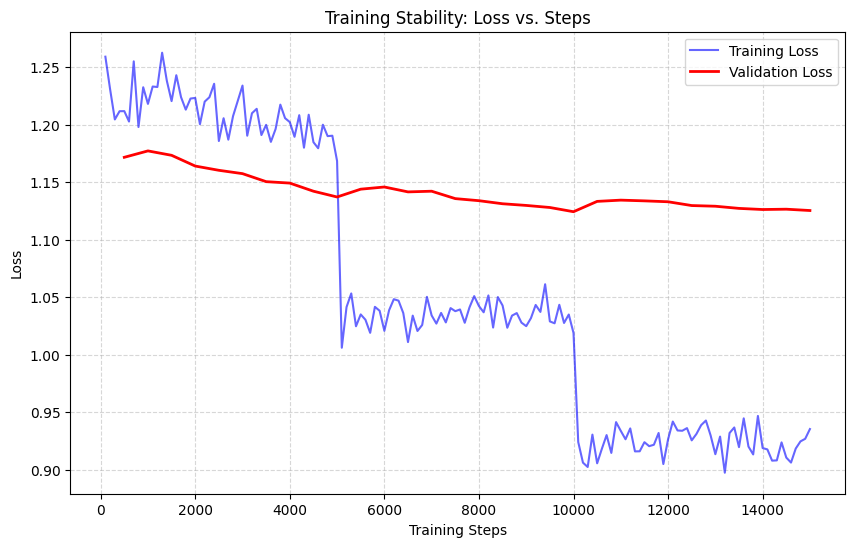

In [22]:
import matplotlib.pyplot as plt
import json

def plot_training_history(log_path):
    """
    Plots the training and validation loss from saved training logs.
    """
    with open(log_path, "r") as f:
        history = json.load(f)
    
    # Extract loss values
    train_loss = []
    val_loss = []
    train_steps = []
    val_steps = []
    
    for entry in history:
        if 'loss' in entry:
            train_loss.append(entry['loss'])
            train_steps.append(entry['step'])
        if 'eval_loss' in entry:
            val_loss.append(entry['eval_loss'])
            val_steps.append(entry['step'])
            
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(train_steps, train_loss, label='Training Loss', color='blue', alpha=0.6)
    plt.plot(val_steps, val_loss, label='Validation Loss', color='red', linewidth=2)
    
    plt.title('Training Stability: Loss vs. Steps')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

plot_training_history("seq2seq_model_opus-mt-en-fr/training_logs.json")

# 3. Evaluation and results

### Translation example and Analysis

In [105]:
# Show side-by-side comparisons for all three models
print("Side-by-Side Translation Comparison (All Three Models):\n")
num_examples = 5
for i in range(min(num_examples, len(test_pairs))):
    en, fr_true = test_pairs[i]
    fr_baseline = baseline_model.translate_preserve_case(en)
    fr_embedding = embedding_model.translate(en)
    fr_seq2seq = seq2seq_model.translate(en, num_beams=4)
    
    print(f"{'='*80}")
    print(f"Example {i+1}")
    print(f"{'='*80}")
    print(f"EN:  {en}")
    print(f"\nFR (True):      {fr_true}")
    print(f"FR (Baseline):  {fr_baseline}")
    print(f"FR (Embedding): {fr_embedding}")
    print(f"FR (Seq2Seq):   {fr_seq2seq}")
    print()

Side-by-Side Translation Comparison (All Three Models):

Example 1
EN:  You see, if we want to train professionals effectively, it is essential to teach them to understand the European and international dimensions of the market in their fields - and to do so at European level too.

FR (True):      Voyez-vous, si nous voulons former des professionnels dans une optique d'efficacité, il est essentiel, y compris au niveau européen, de les former à appréhender les dimensions européenne et internationale du marché dans leurs domaines d'activité.
FR (Baseline):  Vous que si nous nous de train la de il est est de enseigner les de je la L et la dimensions de la marché dans de domaines et de ne de à L niveau trop
FR (Embedding): Nous devons développer la compétitivité de l'industrie européenne au niveau mondial dans l'intérêt des citoyens européens.
FR (Seq2Seq):   Vous voyez, si nous voulons former efficacement les professionnels, il est essentiel de leur apprendre à comprendre les dimensions e

### BLEU scores 
We'll evaluate all three models using BLEU score and other metrics.

In [111]:
import os
import json
import numpy as np
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.tokenize import word_tokenize

try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    print("Downloading missing NLTK resource: punkt_tab")
    nltk.download('punkt_tab')
    nltk.download('punkt')

def evaluate_translations(model, test_pairs, model_name="Model", max_samples=None, save_dir="./results"):
    """
    Evaluate translation model on test set and SAVE RESULTS to disk.
    """
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    if max_samples:
        test_subset = test_pairs[:max_samples]
    else:
        test_subset = test_pairs
    
    print(f"Evaluating {model_name} on {len(test_subset):,} test examples...")
    
    predictions = []
    references = []
    bleu_scores = []
    exact_matches = 0
    smoothing = SmoothingFunction().method1
    
    for i, (en, fr_true) in enumerate(test_subset):
        try:
            # Handle different model output types
            fr_pred = model.translate(en)
            if isinstance(fr_pred, list): 
                fr_pred = fr_pred[0] 
            
            predictions.append(fr_pred)
            references.append(fr_true)
            
            # Tokenize for BLEU (using the downloaded punkt_tab)
            pred_tokens = word_tokenize(fr_pred.lower())
            ref_tokens = word_tokenize(fr_true.lower())
            
            # Calculate BLEU score
            bleu = sentence_bleu([ref_tokens], pred_tokens, smoothing_function=smoothing)
            bleu_scores.append(bleu)
            
            # Exact match
            if fr_pred.lower().strip() == fr_true.lower().strip():
                exact_matches += 1
                
        except Exception as e:
            print(f"Error on example {i}: {e}")
            continue
        
        if (i + 1) % 1000 == 0:
            print(f"  Processed {i+1:,} examples...")
    
    avg_bleu = np.mean(bleu_scores) if bleu_scores else 0.0
    exact_match_rate = exact_matches / len(test_subset) if test_subset else 0.0
    
    results = {
        'model_name': model_name,
        'avg_bleu': float(avg_bleu),
        'exact_match_rate': float(exact_match_rate),
        'num_evaluated': len(test_subset),
        'predictions': predictions,
        'references': references
    }
    
    print(f"\n{model_name} Results:")
    print(f"  Average BLEU Score: {avg_bleu:.4f}")
    print(f"  Exact Match Rate: {exact_match_rate:.4f} ({exact_matches}/{len(test_subset)})")

    # Save results
    safe_name = model_name.replace(" ", "_").replace("/", "_").replace("(", "").replace(")", "")
    save_path = os.path.join(save_dir, f"{safe_name}_results.json")
    
    with open(save_path, "w", encoding='utf-8') as f:
        json.dump(results, f, ensure_ascii=False, indent=4)
    print(f"Results saved to {save_path}")
    
    return results

In [ ]:
# Evaluate baseline model
print("=" * 60)
baseline_results = evaluate_translations(
    baseline_model, 
    test_pairs, 
    model_name="Baseline (Word-for-Word)",
    max_samples=10000  # for speed
)

Evaluating Baseline (Word-for-Word) on 10,000 test examples...
  Processed 1,000 examples...
  Processed 2,000 examples...
  Processed 3,000 examples...
  Processed 4,000 examples...
  Processed 5,000 examples...
  Processed 6,000 examples...
  Processed 7,000 examples...
  Processed 8,000 examples...
  Processed 9,000 examples...
  Processed 10,000 examples...

Baseline (Word-for-Word) Results:
  Average BLEU Score: 0.0378
  Exact Match Rate: 0.0005 (5/10000)
Results saved to ./results/Baseline_Word-for-Word_results.json


In [77]:
# Evaluate embedding model
print("=" * 60)
embedding_results = evaluate_translations(
    embedding_model,
    test_pairs,
    model_name="Advanced (Cross-Lingual Embeddings)",
    max_samples=10000  # for speed
)

Evaluating Advanced (Cross-Lingual Embeddings) on 10,000 test examples...
  Processed 1,000 examples...
  Processed 2,000 examples...
  Processed 3,000 examples...
  Processed 4,000 examples...
  Processed 5,000 examples...
  Processed 6,000 examples...
  Processed 7,000 examples...
  Processed 8,000 examples...
  Processed 9,000 examples...
  Processed 10,000 examples...

Advanced (Cross-Lingual Embeddings) Results:
  Average BLEU Score: 0.0488
  Exact Match Rate: 0.0071 (71/10000)
Results saved to ./results/Advanced_Cross-Lingual_Embeddings_results.json


In [78]:
# Evaluate seq2seq model
print("=" * 60)
seq2seq_results = evaluate_translations(
    seq2seq_model,
    test_pairs,
    model_name="Best Model (Seq2Seq Transformer)",
    max_samples=10000   # for speed
)

Evaluating Best Model (Seq2Seq Transformer) on 10,000 test examples...
  Processed 1,000 examples...
  Processed 2,000 examples...
  Processed 3,000 examples...
  Processed 4,000 examples...
  Processed 5,000 examples...
  Processed 6,000 examples...
  Processed 7,000 examples...
  Processed 8,000 examples...
  Processed 9,000 examples...
  Processed 10,000 examples...

Best Model (Seq2Seq Transformer) Results:
  Average BLEU Score: 0.3224
  Exact Match Rate: 0.0351 (351/10000)
Results saved to ./results/Best_Model_Seq2Seq_Transformer_results.json


In [79]:
# Compare all three models
print("\n" + "=" * 80)
print("MODEL COMPARISON - ALL THREE MODELS")
print("=" * 80)
print(f"{'Metric':<30} {'Baseline':<20} {'Embeddings':<20} {'Seq2Seq':<20}")
print("-" * 80)
print(f"{'Average BLEU Score':<30} {baseline_results['avg_bleu']:<20.4f} {embedding_results['avg_bleu']:<20.4f} {seq2seq_results['avg_bleu']:<20.4f}")
print(f"{'Exact Match Rate':<30} {baseline_results['exact_match_rate']:<20.4f} {embedding_results['exact_match_rate']:<20.4f} {seq2seq_results['exact_match_rate']:<20.4f}")
print(f"{'Number Evaluated':<30} {baseline_results['num_evaluated']:<20} {embedding_results['num_evaluated']:<20} {seq2seq_results['num_evaluated']:<20}")

# Calculate improvements
embedding_improvement = embedding_results['avg_bleu'] - baseline_results['avg_bleu']
seq2seq_improvement = seq2seq_results['avg_bleu'] - baseline_results['avg_bleu']
seq2seq_vs_embedding = seq2seq_results['avg_bleu'] - embedding_results['avg_bleu']

print(f"\n{'Improvements over Baseline:':<30}")
print(f"  Embeddings: {embedding_improvement:+.4f} ({embedding_improvement/baseline_results['avg_bleu']*100:+.2f}%)")
print(f"  Seq2Seq:    {seq2seq_improvement:+.4f} ({seq2seq_improvement/baseline_results['avg_bleu']*100:+.2f}%)")
print(f"\nSeq2Seq vs Embeddings: {seq2seq_vs_embedding:+.4f} ({seq2seq_vs_embedding/embedding_results['avg_bleu']*100:+.2f}%)")

# Determine winner
best_model = max([
    ('Baseline', baseline_results['avg_bleu']),
    ('Embeddings', embedding_results['avg_bleu']),
    ('Seq2Seq', seq2seq_results['avg_bleu'])
], key=lambda x: x[1])

print(f"\nBest Model: {best_model[0]} (BLEU: {best_model[1]:.4f})")


MODEL COMPARISON - ALL THREE MODELS
Metric                         Baseline             Embeddings           Seq2Seq             
--------------------------------------------------------------------------------
Average BLEU Score             0.0378               0.0488               0.3224              
Exact Match Rate               0.0005               0.0071               0.0351              
Number Evaluated               10000                10000                10000               

Improvements over Baseline:   
  Embeddings: +0.0110 (+28.98%)
  Seq2Seq:    +0.2846 (+752.50%)

Seq2Seq vs Embeddings: +0.2736 (+560.94%)

Best Model: Seq2Seq (BLEU: 0.3224)


### Translation quality

In [80]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.tokenize import word_tokenize

def plot_performance_by_length(model, test_pairs, max_samples=1000):
    """
    Plots BLEU score vs. Sentence Length.
    """    
    # 1. Generate Data
    lengths = []
    scores = []
    
    smoothing = SmoothingFunction().method1
    
    # Use a subset for speed
    subset = test_pairs[:max_samples]
    
    for en, fr_true in subset:
        try:
            # Translate
            fr_pred = model.translate(en)
            if isinstance(fr_pred, list): fr_pred = fr_pred[0] # Handle embedding model
            
            # Tokenize
            ref_tokens = word_tokenize(fr_true.lower())
            pred_tokens = word_tokenize(fr_pred.lower())
            
            # Calculate BLEU
            score = sentence_bleu([ref_tokens], pred_tokens, smoothing_function=smoothing)
            
            # Record Length (English word count) and Score
            lengths.append(len(en.split()))
            scores.append(score)
            
        except Exception:
            continue

    # 2. Create DataFrame for Analysis
    df = pd.DataFrame({'length': lengths, 'bleu': scores})
    
    # 3. Bin the lengths (e.g., 0-10 words, 10-20 words...)
    bins = [0, 10, 20, 30, 40, 50, 100]
    labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50+']
    df['length_bin'] = pd.cut(df['length'], bins=bins, labels=labels)
    
    # 4. Calculate Average BLEU per bin
    bin_scores = df.groupby('length_bin')['bleu'].mean()
    
    # 5. Plot
    plt.figure(figsize=(10, 6))
    bin_scores.plot(kind='bar', color='skyblue', edgecolor='black')
    
    plt.title('Translation Quality by Sentence Length')
    plt.xlabel('Input Sentence Length (Words)')
    plt.ylabel('Average BLEU Score')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.xticks(rotation=0)
    
    # Add value labels on top of bars
    for i, v in enumerate(bin_scores):
        if not np.isnan(v):
            plt.text(i, v + 0.01, f"{v:.2f}", ha='center')
            
    plt.show()

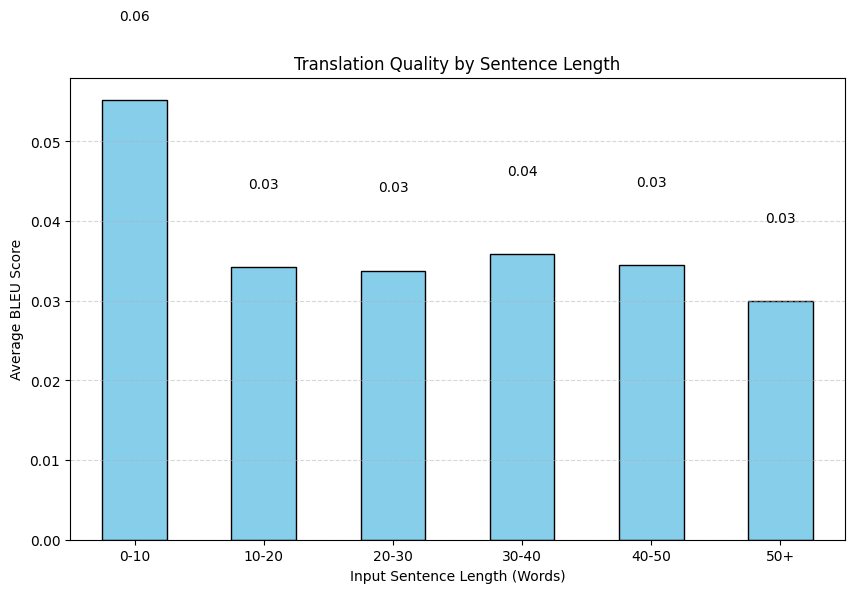

In [81]:
plot_performance_by_length(baseline_model, test_pairs)

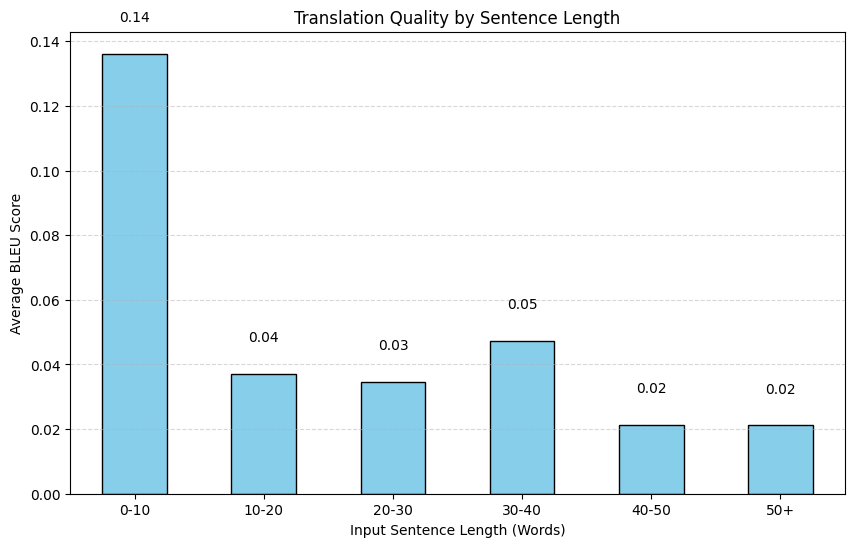

In [82]:
plot_performance_by_length(embedding_model, test_pairs)

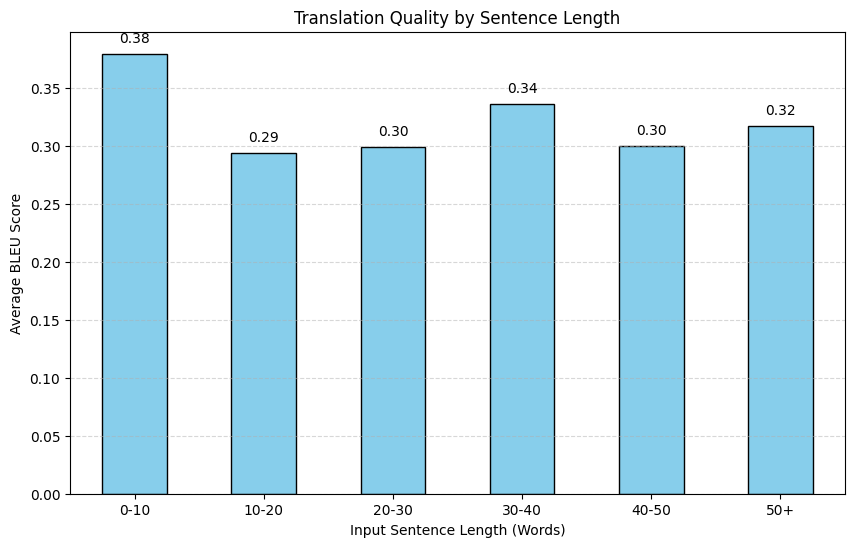

In [83]:
plot_performance_by_length(seq2seq_model, test_pairs)

### Cosine-similarity

After training your Transformer, we want to prove it learned "meaning" and not just memorization. We do this by checking if English words are "close" to their French equivalents in vector space.

In [84]:
import torch.nn.functional as F

def check_embedding_alignment(model, tokenizer, en_word, fr_word):
    """
    Computes cosine similarity between an English word and a French word
    inside the model's learned embedding space.
    """
    # 1. Get IDs
    en_id = tokenizer.encode(en_word, add_special_tokens=False)[0]
    fr_id = tokenizer.encode(fr_word, add_special_tokens=False)[0]
    
    # 2. Get Vectors (Embeddings) from the model
    # Note: Model specific. For Helsinki-NLP, it's model.model.shared or similar
    # This assumes a shared embedding layer (common in EN-FR models)
    embeddings = model.get_input_embeddings()
    
    vec_en = embeddings(torch.tensor(en_id).to(model.device)).unsqueeze(0)
    vec_fr = embeddings(torch.tensor(fr_id).to(model.device)).unsqueeze(0)
    
    # 3. Compute Cosine Similarity
    sim = F.cosine_similarity(vec_en, vec_fr)
    
    print(f"Similarity ('{en_word}' <-> '{fr_word}'): {sim.item():.4f}")

In [85]:
# High similarity expected (e.g., > 0.4)
check_embedding_alignment(embedding_model.model[0].auto_model, embedding_model.model.tokenizer, "parliament", "parlement")
check_embedding_alignment(embedding_model.model[0].auto_model, embedding_model.model.tokenizer, "president", "président")

# Low similarity expected (e.g., < 0.1)
check_embedding_alignment(embedding_model.model[0].auto_model, embedding_model.model.tokenizer, "apple", "voiture")

Similarity ('parliament' <-> 'parlement'): 0.2141
Similarity ('president' <-> 'président'): 0.7067
Similarity ('apple' <-> 'voiture'): 0.1805


In [86]:
# High similarity expected (e.g., > 0.4)
check_embedding_alignment(seq2seq_model.model, seq2seq_model.tokenizer, "parliament", "parlement")
check_embedding_alignment(seq2seq_model.model, seq2seq_model.tokenizer, "president", "président")

# Low similarity expected (e.g., < 0.1)
check_embedding_alignment(seq2seq_model.model, seq2seq_model.tokenizer, "apple", "voiture")

Similarity ('parliament' <-> 'parlement'): 0.3425
Similarity ('president' <-> 'président'): 0.3982
Similarity ('apple' <-> 'voiture'): 0.5168


###  Word analogies - the analogy function 

In [87]:
import torch
import torch.nn.functional as F

def solve_analogy(model, tokenizer, word_a, word_b, word_c):
    """
    Solves: word_a is to word_b as word_c is to ?
    Equation: b - a + c = ?
    """
    # 1. Get the Embedding Matrix (The model's vocabulary)
    # This is the static lookup table before layers
    embeddings = model.get_input_embeddings().weight.detach()
    
    # 2. Helper to get vector for a word
    def get_vec(w):
        # We take the first subword token ID if it splits
        idx = tokenizer.encode(w, add_special_tokens=False)[0]
        return embeddings[idx]

    # 3. Compute Target Vector
    vec_a = get_vec(word_a)
    vec_b = get_vec(word_b)
    vec_c = get_vec(word_c)
    
    # Target = b - a + c
    target_vec = vec_b - vec_a + vec_c
    
    # 4. Find closest word in the entire vocabulary
    # Cosine sim between target_vec and ALL embeddings
    similarities = F.cosine_similarity(target_vec.unsqueeze(0), embeddings)
    
    # Get top match (ignoring the input words themselves if they appear)
    best_idx = torch.argmax(similarities).item()
    best_word = tokenizer.decode([best_idx])
    
    print(f"Analogy: {word_a} -> {word_b} :: {word_c} -> {best_word}")
    return best_word

In [88]:
print("=== Word Analogies ===")
# Semantic: Capital Cities
solve_analogy(embedding_model.model[0].auto_model, embedding_model.model.tokenizer, "France", "Paris", "Germany") 
# Semantic: Gender
solve_analogy(embedding_model.model[0].auto_model, embedding_model.model.tokenizer, "man", "king", "woman") 
# Grammatical: Plurals (if model learned grammar)
solve_analogy(embedding_model.model[0].auto_model, embedding_model.model.tokenizer, "car", "cars", "apple")

=== Word Analogies ===
Analogy: France -> Paris :: Germany -> Paris
Analogy: man -> king :: woman -> king
Analogy: car -> cars :: apple -> apple


'apple'

In [89]:
print("=== Word Analogies ===")
# Semantic: Capital Cities
solve_analogy(seq2seq_model.model, seq2seq_model.tokenizer, "France", "Paris", "Germany") 
# Semantic: Gender
solve_analogy(seq2seq_model.model, seq2seq_model.tokenizer, "man", "king", "woman") 
# Grammatical: Plurals (if model learned grammar)
solve_analogy(seq2seq_model.model, seq2seq_model.tokenizer, "car", "cars", "apple")

=== Word Analogies ===
Analogy: France -> Paris :: Germany -> Germany
Analogy: man -> king :: woman -> woman
Analogy: car -> cars :: apple -> apple


'apple'

### PCA visualizations

In [90]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import torch

def visualize_embedding_clusters(model, tokenizer):
    """
    Projects specific word groups to 2D using PCA to show semantic clustering.
    """
    # 1. Define groups of words to visualize
    word_groups = {
        "Months": ["january", "february", "march", "april", "may", "june", "july", "august"],
        "Family": ["mother", "father", "sister", "brother", "daughter", "son", "aunt", "uncle"],
        "Politics": ["parliament", "president", "commission", "vote", "council", "union", "treaty"],
        "Verbs": ["speak", "vote", "decide", "agree", "reject", "propose", "debate"]
    }
    
    # 2. Extract Embeddings
    embeddings = model.get_input_embeddings().weight.detach().cpu()
    
    selected_words = []
    selected_vecs = []
    labels = []
    
    for category, words in word_groups.items():
        for w in words:
            # Handle tokenization (use first subword)
            ids = tokenizer.encode(w, add_special_tokens=False)
            if ids:
                idx = ids[0]
                selected_vecs.append(embeddings[idx].numpy())
                selected_words.append(w)
                labels.append(category)
    
    # 3. Apply PCA (Reduce to 2D)
    pca = PCA(n_components=2)
    # We must stack the list of arrays into a 2D matrix
    X_2d = pca.fit_transform(np.stack(selected_vecs))
    
    # 4. Plot
    plt.figure(figsize=(10, 8))
    
    # Map categories to colors
    unique_labels = list(word_groups.keys())
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
    color_map = dict(zip(unique_labels, colors))
    
    for i, word in enumerate(selected_words):
        cat = labels[i]
        x, y = X_2d[i]
        plt.scatter(x, y, color=color_map[cat], s=100, alpha=0.7)
        plt.text(x+0.02, y+0.02, word, fontsize=9)
        
    # Create legend manually
    markers = [plt.Line2D([0,0],[0,0], color=color, marker='o', linestyle='') for color in colors]
    plt.legend(markers, unique_labels, title="Semantic Category")
    
    plt.title("PCA Projection of Learned Word Embeddings")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.grid(True, alpha=0.3)
    plt.show()

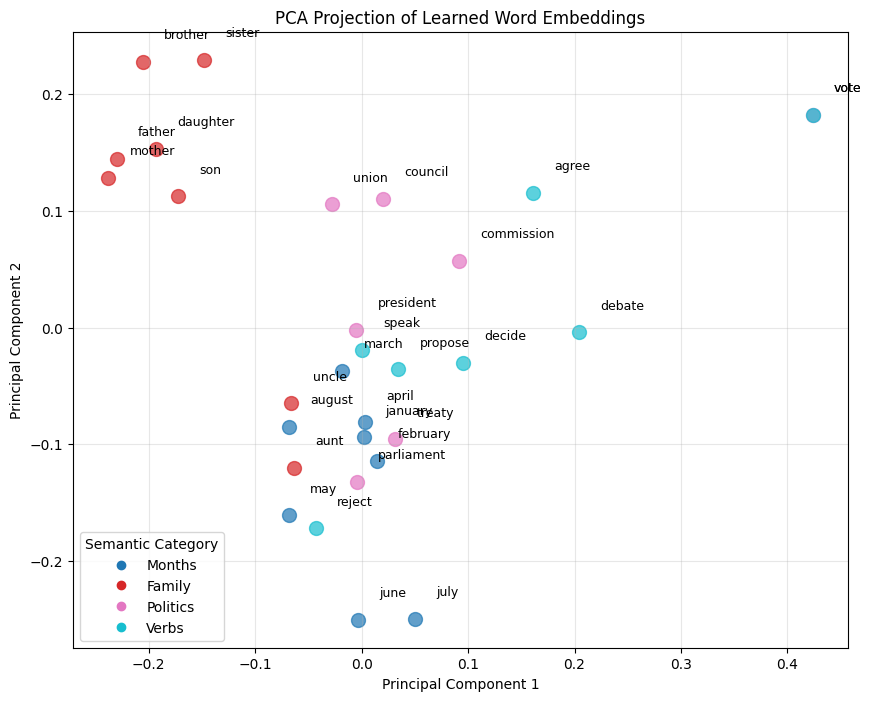

In [91]:
visualize_embedding_clusters(embedding_model.model[0].auto_model, embedding_model.model.tokenizer)

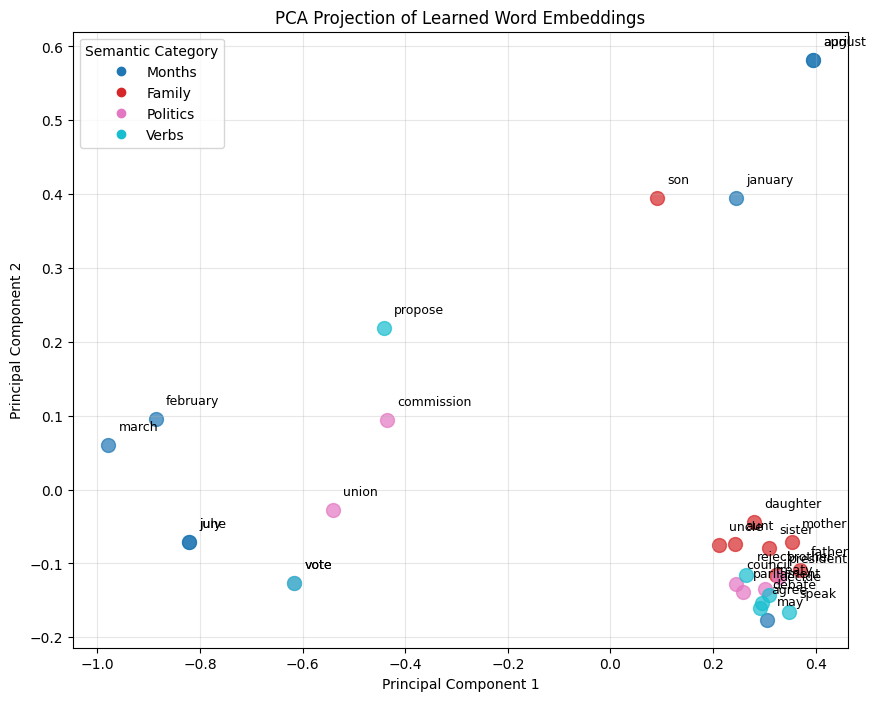

In [92]:
visualize_embedding_clusters(seq2seq_model.model, seq2seq_model.tokenizer)

In [93]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import torch

def visualize_en_fr_alignment(model, tokenizer):
    """
    Plots English words and their French translations in the same 2D space.
    Draws lines between them to visualize alignment.
    """
    # 1. Define Pairs (Concepts)
    # We choose distinct concepts to see if they separate well
    concept_pairs = [
        ("monday", "lundi"), ("friday", "vendredi"),   # Days
        ("man", "homme"), ("woman", "femme"),         # People
        ("president", "président"), ("law", "loi"),   # Politics
        ("apple", "pomme"), ("bread", "pain"),        # Food
        ("red", "rouge"), ("blue", "bleu")            # Colors
    ]
    
    # 2. Extract Embeddings
    # We need the shared embedding layer
    embeddings = model.get_input_embeddings().weight.detach().cpu()
    
    vecs = []
    labels = []
    colors = [] # Store color for each point
    
    for en, fr in concept_pairs:
        # Get English Vector
        en_id = tokenizer.encode(en, add_special_tokens=False)[0]
        fr_id = tokenizer.encode(fr, add_special_tokens=False)[0]
        
        vecs.append(embeddings[en_id].numpy())
        vecs.append(embeddings[fr_id].numpy())
        
        labels.append(en) # Label English
        labels.append(fr) # Label French
        
        colors.append("blue") # English color
        colors.append("red")  # French color

    # 3. PCA to 2D
    # Important: We fit PCA on ALL vectors together so they share the map
    pca = PCA(n_components=2)
    X_2d = pca.fit_transform(np.array(vecs))
    
    # 4. Plot
    plt.figure(figsize=(10, 8))
    
    # Plot points
    for i in range(len(labels)):
        plt.scatter(X_2d[i, 0], X_2d[i, 1], color=colors[i], s=100)
        # Offset label slightly
        plt.text(X_2d[i, 0]+0.02, X_2d[i, 1]+0.02, labels[i], fontsize=11)

    # Draw lines connecting the pairs
    # The list 'vecs' is ordered [En1, Fr1, En2, Fr2...]
    # So we connect index 0-1, 2-3, etc.
    for i in range(0, len(vecs), 2):
        p1 = X_2d[i]   # English
        p2 = X_2d[i+1] # French
        plt.plot([p1[0], p2[0]], [p1[1], p2[1]], 'k--', alpha=0.3)

    # Legend
    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], color='blue', marker='o', linestyle=''),
                    Line2D([0], [0], color='red', marker='o', linestyle='')]
    plt.legend(custom_lines, ['English', 'French'])

    plt.title("Cross-Lingual Alignment (English vs French)")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.grid(True, alpha=0.3)
    plt.show()

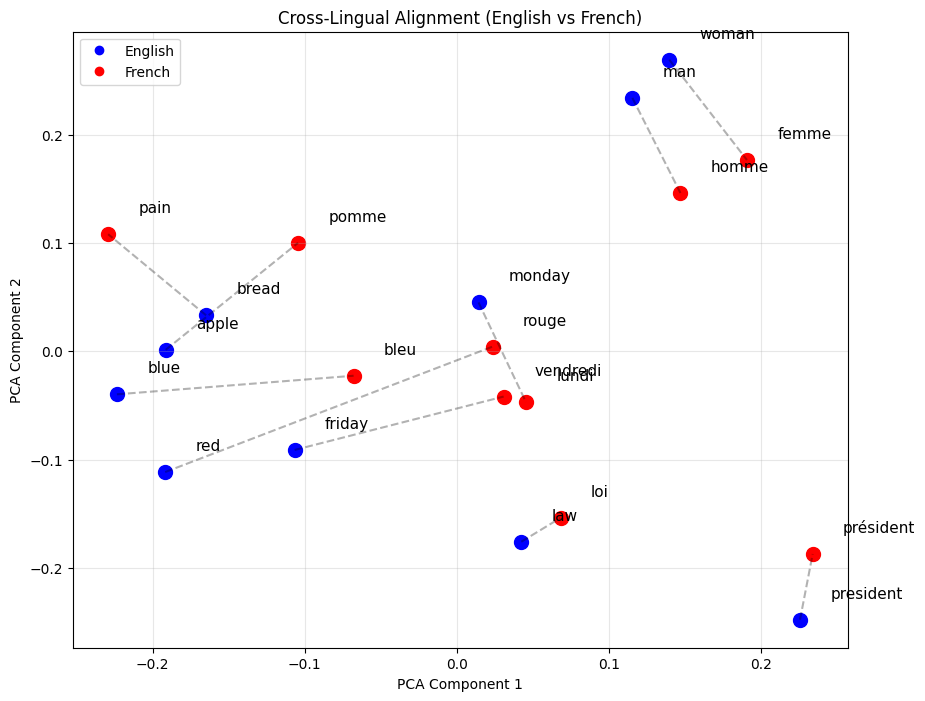

In [94]:
visualize_en_fr_alignment(embedding_model.model[0].auto_model, embedding_model.model.tokenizer)

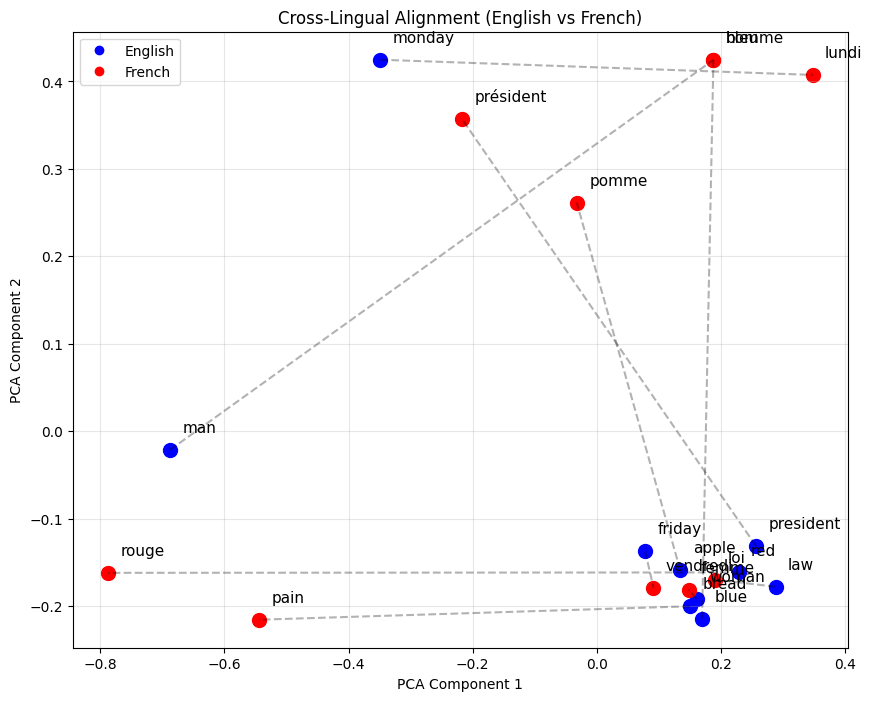

In [95]:
visualize_en_fr_alignment(seq2seq_model.model, seq2seq_model.tokenizer)

### Polysemy test: "party"

In [114]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torch.nn.functional as F

def analyze_polysemy(model, tokenizer, sentences):
    """
    Analyzes how the model represents the word 'party' in different contexts.
    Combines robust model calling with enhanced visualization.
    """
    word_of_interest = "party"
    
    # 1. Helper to get the word's representation pattern
    def get_contextual_pattern(text, target_word):
        inputs = tokenizer(text, return_tensors="pt")
        input_ids = inputs["input_ids"].to(model.device)
        
        # Standard processing for BERT-based models
        with torch.no_grad():
            outputs = model(input_ids)
            # Safely handle different model output formats
            last_hidden_state = outputs.last_hidden_state if hasattr(outputs, 'last_hidden_state') else outputs[0]
            
        # Find the specific word in the text
        target_ids = tokenizer.encode(target_word, add_special_tokens=False)
        if len(target_ids) == 0:
            return None
        target_id = target_ids[0]
        
        indices = (input_ids[0] == target_id).nonzero(as_tuple=True)[0]
        if len(indices) == 0:
            print(f"Warning: '{target_word}' not found or split differently in: {text}")
            return None
            
        idx = indices[0].item() 
        return last_hidden_state[0, idx, :].cpu() 

    # 2. Collect patterns and labels
    patterns = []
    labels = []
    colors = []
    
    color_map = {"Political": "blue", "Social": "red", "Ambiguous": "purple"}
    
    print(f"Analyzing how the model understands '{word_of_interest}'...")
    
    pattern_political_a = None
    pattern_social_a = None
    pattern_ambiguous = None

    for label, text in sentences.items():
        pattern = get_contextual_pattern(text, word_of_interest)
        if pattern is not None:
            patterns.append(pattern.numpy())
            labels.append(label)
            
            # Assign color based on the first word of the label
            category = label.split()[0]
            colors.append(color_map.get(category, "black"))
            
            # Save specific ones for similarity checks
            if label == "Political (A)": pattern_political_a = pattern
            if label == "Social (A)": pattern_social_a = pattern
            if label == "Ambiguous": pattern_ambiguous = pattern

    # 3. Check Similarity Scores
    if pattern_political_a is not None and pattern_social_a is not None and pattern_ambiguous is not None:
        # Calculate how close the meanings are to each other
        sim_pol_soc = F.cosine_similarity(pattern_political_a.unsqueeze(0), pattern_social_a.unsqueeze(0)).item()
        sim_amb_pol = F.cosine_similarity(pattern_ambiguous.unsqueeze(0), pattern_political_a.unsqueeze(0)).item()
        sim_amb_soc = F.cosine_similarity(pattern_ambiguous.unsqueeze(0), pattern_social_a.unsqueeze(0)).item()
        
        print("\n" + "="*60)
        print("SIMILARITY SCORES")
        print("="*60)
        print(f"Similarity (Political A <-> Social A): {sim_pol_soc:.4f}")
        print(f"Similarity (Ambiguous <-> Political A): {sim_amb_pol:.4f}")
        print(f"Similarity (Ambiguous <-> Social A):    {sim_amb_soc:.4f}")
        
    # 4. Create Visual Map
    if len(patterns) > 1:
        # Flatten the complex patterns into a 2D map for visualization
        pca = PCA(n_components=2)
        coords = pca.fit_transform(np.stack(patterns))
        
        plt.figure(figsize=(10, 7))
        for i, (label, color) in enumerate(zip(labels, colors)):
            x, y = coords[i]
            plt.scatter(x, y, c=color, s=200, edgecolors='k', zorder=5)
            plt.text(x+0.05, y+0.05, label, fontsize=12, fontweight='bold')
            
            # Add the full sentence as a subtitle
            full_text = sentences[label]
            plt.text(x+0.05, y-0.1, f'"{full_text}"', fontsize=8, alpha=0.7, style='italic')

        # Try to draw a line between the two main distinct meanings if they exist in the coords
        try:
            pol_idx = labels.index("Political (A)")
            soc_idx = labels.index("Social (A)")
            p1 = coords[pol_idx]
            p2 = coords[soc_idx]
            plt.plot([p1[0], p2[0]], [p1[1], p2[1]], 'k--', alpha=0.3, label="Meaning Gap")
            plt.legend()
        except ValueError:
            pass # Skip the line if those exact labels aren't present

        plt.title(f"Model Understanding Map: '{word_of_interest}' in Context")
        plt.xlabel("Map Component 1")
        plt.ylabel("Map Component 2")
        plt.grid(True, alpha=0.3)
        plt.show()

In [115]:
sentences = {
    "Political (A)": "The conservative party voted against the law.",
    "Political (B)": "This political party has a majority in parliament.",
    "Social (A)": "I am going to a birthday party tonight.",
    "Social (B)": "The dinner party was very fun and loud.",
    "Ambiguous": "The party was strictly regulated."  
}

Analyzing how the model understands 'party'...

SIMILARITY SCORES
Similarity (Political A <-> Social A): 0.4425
Similarity (Ambiguous <-> Political A): 0.8116
Similarity (Ambiguous <-> Social A):    0.5920


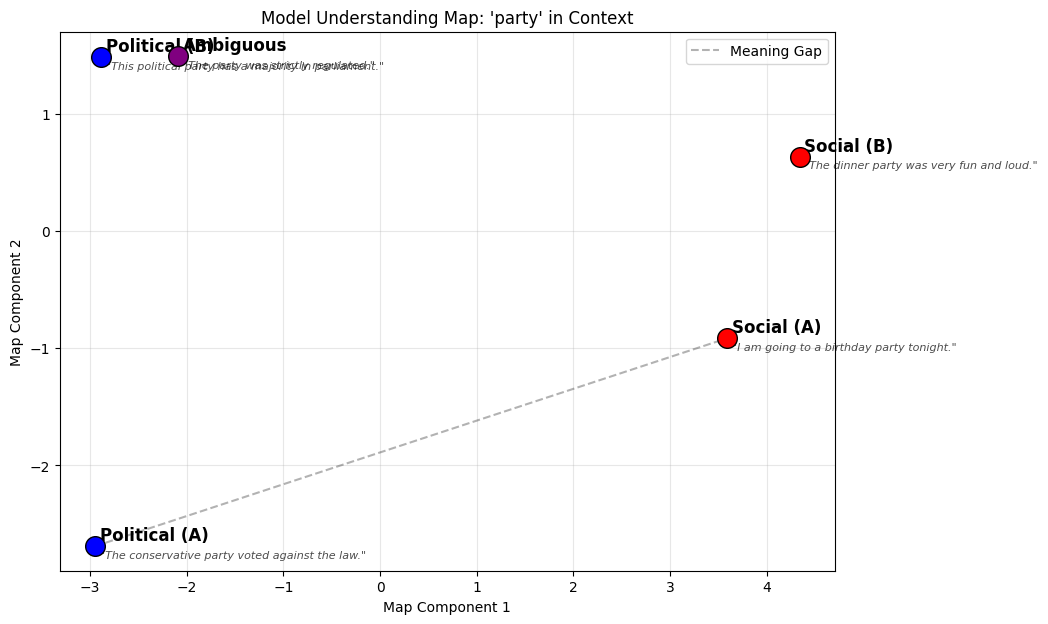

In [116]:
analyze_polysemy(embedding_model.model[0].auto_model, embedding_model.model.tokenizer, sentences)

Analyzing contextual embeddings for 'party'...

COSINE SIMILARITY ANALYSIS
Similarity (Political A <-> Social A): 0.3854
Similarity (Ambiguous <-> Political A): 0.8813
Similarity (Ambiguous <-> Social A):    0.4509


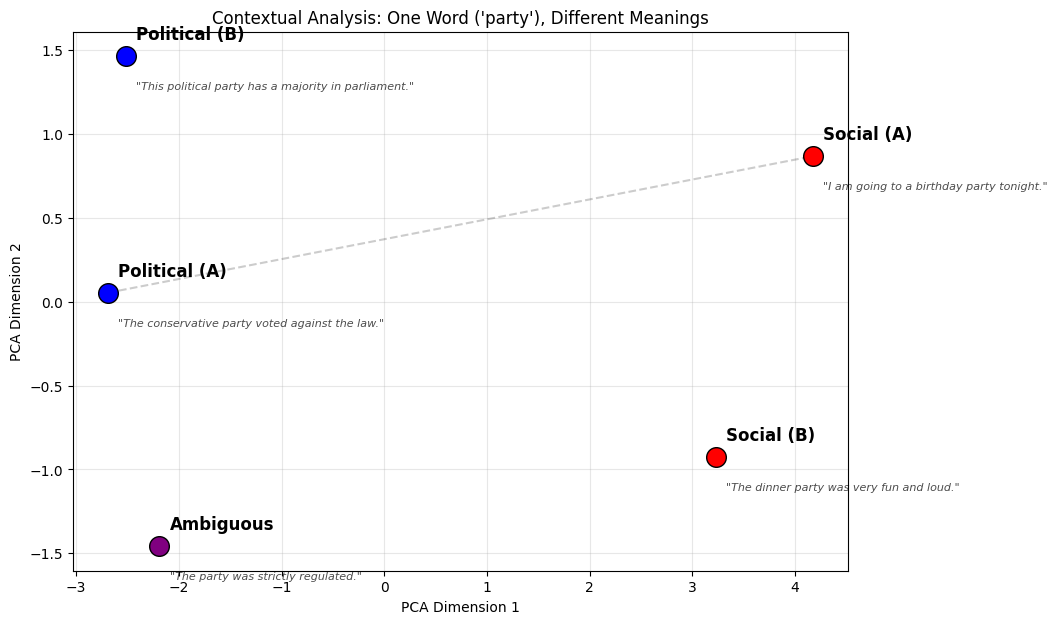

In [117]:
analyze_polysemy_bert(seq2seq_model.model, seq2seq_model.tokenizer, sentences)

# 4. Error Analysis
### N-gram Level BLEU Breakdown (BLEU-1 / BLEU-2 / BLEU-3 / BLEU-4)

The standard BLEU score is a geometric mean of n-gram precisions. By decomposing it into individual n-gram levels, we can understand **where** each model fails:

- **BLEU-1 (unigrams):** Measures how many individual words in the prediction appear in the reference. A high BLEU-1 means the model uses the right vocabulary.
- **BLEU-2 (bigrams):** Measures correct two-word sequences. Captures basic word adjacency and local word order.
- **BLEU-3 (trigrams):** Measures correct three-word phrases. Captures short syntactic patterns.
- **BLEU-4 (4-grams):** Measures correct four-word sequences. Captures fluency and grammatical structure.

**Expected behavior:**
- The **Baseline** (word-for-word) should have a reasonable BLEU-1 (correct individual words) but collapse sharply at BLEU-3/4 because it produces no coherent phrasing.
- The **Embedding** model retrieves whole sentences, so it may have some n-gram overlap if it finds a semantically similar sentence, but scores should remain low across all levels since it rarely retrieves the exact reference.
- The **Seq2Seq** model should maintain relatively higher scores across all n-gram levels, showing it generates fluent and accurate translations.

In [101]:
import numpy as np
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.tokenize import word_tokenize

def compute_ngram_bleu_breakdown(models, model_names, test_pairs, max_samples=1000):
    """
    Computes BLEU-1, BLEU-2, BLEU-3, BLEU-4 separately for each model
    and produces a grouped bar chart comparison.
    """
    smoothing = SmoothingFunction().method1
    subset = test_pairs[:max_samples]
    
    # Weights for isolating each n-gram level
    weights_map = {
        'BLEU-1': (1, 0, 0, 0),
        'BLEU-2': (0, 1, 0, 0),
        'BLEU-3': (0, 0, 1, 0),
        'BLEU-4': (0, 0, 0, 1),
    }
    
    all_results = {}
    
    for model, name in zip(models, model_names):
        print(f"Computing n-gram BLEU for {name}...")
        
        level_scores = {level: [] for level in weights_map}
        
        for i, (en, fr_true) in enumerate(subset):
            try:
                fr_pred = model.translate(en)
                if isinstance(fr_pred, list):
                    fr_pred = fr_pred[0]
                
                pred_tokens = word_tokenize(fr_pred.lower())
                ref_tokens = word_tokenize(fr_true.lower())
                
                for level, weights in weights_map.items():
                    n = weights.index(1) + 1
                    if len(pred_tokens) >= n and len(ref_tokens) >= n:
                        score = sentence_bleu(
                            [ref_tokens], pred_tokens,
                            weights=weights,
                            smoothing_function=smoothing
                        )
                        level_scores[level].append(score)
                    else:
                        level_scores[level].append(0.0)
                        
            except Exception:
                for level in weights_map:
                    level_scores[level].append(0.0)
            
            if (i + 1) % 500 == 0:
                print(f"  {i+1}/{len(subset)} done...")
        
        all_results[name] = {
            level: np.mean(scores) for level, scores in level_scores.items()
        }
    
    #  Print results table 
    levels = list(weights_map.keys())
    print(f"\n{'='*70}")
    print("N-GRAM BLEU BREAKDOWN")
    print(f"{'='*70}")
    header = f"{'Model':<35}" + "".join(f"{l:<10}" for l in levels)
    print(header)
    print("-" * 70)
    for name in model_names:
        row = f"{name:<35}"
        for level in levels:
            row += f"{all_results[name][level]:<10.4f}"
        print(row)
    
    #  Grouped bar chart 
    x = np.arange(len(levels))
    width = 0.25
    n_models = len(model_names)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    colors = ['#4ECDC4', '#FF6B6B', '#45B7D1']
    
    for i, name in enumerate(model_names):
        scores = [all_results[name][level] for level in levels]
        offset = (i - n_models / 2 + 0.5) * width
        bars = ax.bar(x + offset, scores, width, label=name, color=colors[i], edgecolor='black', linewidth=0.5)
        
        for bar, score in zip(bars, scores):
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005,
                    f'{score:.3f}', ha='center', va='bottom', fontsize=8)
    
    ax.set_xlabel('N-gram Level')
    ax.set_ylabel('Average BLEU Score')
    ax.set_title('N-gram BLEU Breakdown: Lexical Accuracy vs. Fluency')
    ax.set_xticks(x)
    ax.set_xticklabels(levels)
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    ax.set_ylim(0, max(max(all_results[n][l] for l in levels) for n in model_names) * 1.25)
    
    plt.tight_layout()
    plt.show()
    
    return all_results

Computing n-gram BLEU for Baseline (Word-for-Word)...
  500/10000 done...
  1000/10000 done...
  1500/10000 done...
  2000/10000 done...
  2500/10000 done...
  3000/10000 done...
  3500/10000 done...
  4000/10000 done...
  4500/10000 done...
  5000/10000 done...
  5500/10000 done...
  6000/10000 done...
  6500/10000 done...
  7000/10000 done...
  7500/10000 done...
  8000/10000 done...
  8500/10000 done...
  9000/10000 done...
  9500/10000 done...
  10000/10000 done...
Computing n-gram BLEU for Embeddings (Cross-Lingual)...
  500/10000 done...
  1000/10000 done...
  1500/10000 done...
  2000/10000 done...
  2500/10000 done...
  3000/10000 done...
  3500/10000 done...
  4000/10000 done...
  4500/10000 done...
  5000/10000 done...
  5500/10000 done...
  6000/10000 done...
  6500/10000 done...
  7000/10000 done...
  7500/10000 done...
  8000/10000 done...
  8500/10000 done...
  9000/10000 done...
  9500/10000 done...
  10000/10000 done...
Computing n-gram BLEU for Seq2Seq Transformer...
 

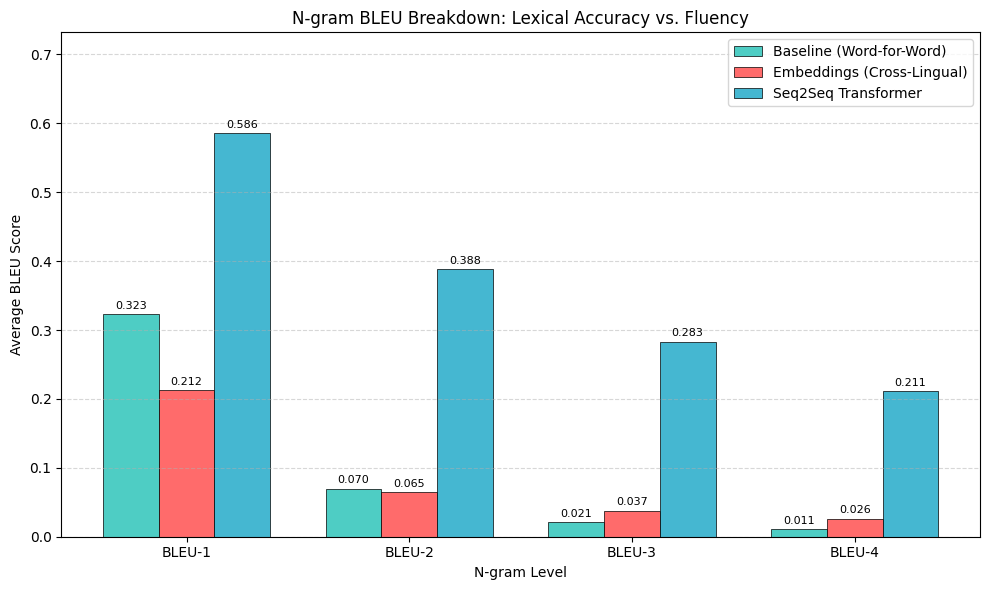

In [102]:
ngram_results = compute_ngram_bleu_breakdown(
    models=[baseline_model, embedding_model, seq2seq_model],
    model_names=['Baseline (Word-for-Word)', 'Embeddings (Cross-Lingual)', 'Seq2Seq Transformer'],
    test_pairs=test_pairs,
    max_samples=10000
)

### Cross-Attention Heatmap

Generating Attention Map from: ./seq2seq_model_opus-mt-en-fr


Loading weights: 100%|██████████| 256/256 [00:00<00:00, 1956.72it/s, Materializing param=model.shared.weight]                                  
The tied weights mapping and config for this model specifies to tie model.shared.weight to model.decoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
The tied weights mapping and config for this model specifies to tie model.shared.weight to model.encoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
/home/mhayakawa/miniconda3/envs/rocm_env/lib/python3.12/site-packages/transformers/models/marian/tokenization_marian.py:176: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


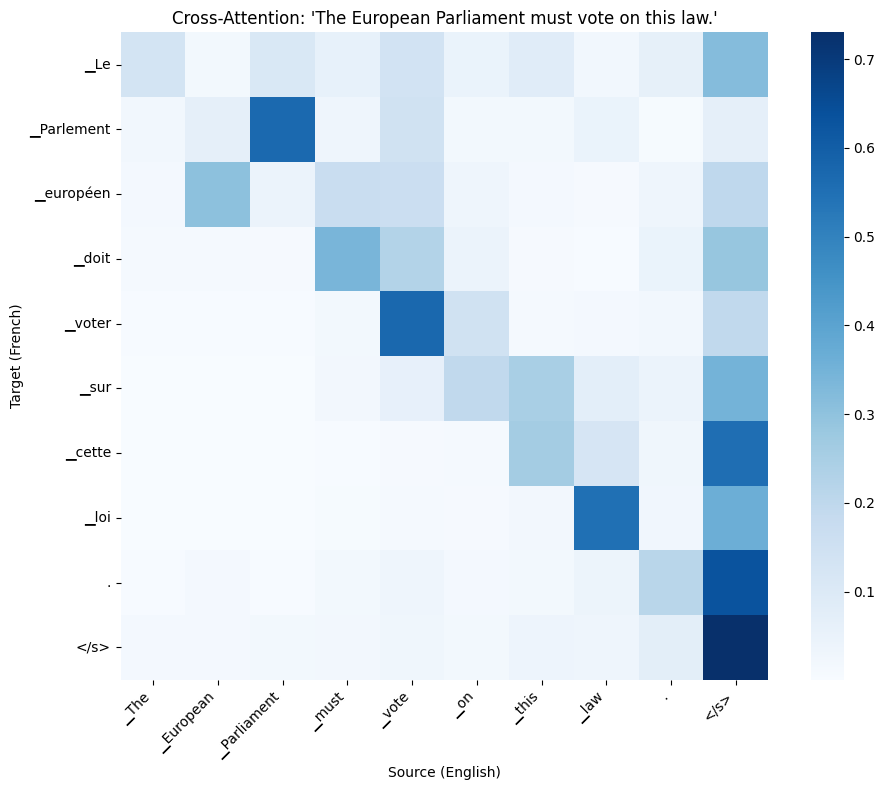

In [104]:
import warnings
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import types

# 1. Suppress the specific "tied weights" warning to keep output clean
warnings.filterwarnings("ignore", message=".*tie_word_embeddings.*")

# 2. Load the trained model with "eager" attention
model_path = "./seq2seq_model_opus-mt-en-fr" 
print(f"Generating Attention Map from: {model_path}")

try:
    # Load model
    viz_model = AutoModelForSeq2SeqLM.from_pretrained(model_path, attn_implementation="eager")
    viz_tokenizer = AutoTokenizer.from_pretrained(model_path)
    
    # Move to GPU/MPS if available
    device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
    viz_model.to(device)

    # 3. Create wrapper object
    viz_wrapper = types.SimpleNamespace()
    viz_wrapper.model = viz_model
    viz_wrapper.tokenizer = viz_tokenizer
    viz_wrapper.device = device

    # 4. Define the plotting function (Robust version)
    def plot_attention_map(model_wrapper, text):
        model = model_wrapper.model
        tokenizer = model_wrapper.tokenizer
        device = model_wrapper.device
        
        # Enable attention outputs
        model.config.output_attentions = True
        
        # Tokenize
        inputs = tokenizer(text, return_tensors="pt").to(device)
        
        # Generate with Greedy Search
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                output_attentions=True,
                return_dict_in_generate=True,
                max_length=50,
                num_beams=1 # Greedy search for simple 1-to-1 attention
            )
        
        # Get tokens
        input_tokens = tokenizer.convert_ids_to_tokens(inputs.input_ids[0])
        output_ids = outputs.sequences[0]
        output_tokens = tokenizer.convert_ids_to_tokens(output_ids)
        
        # Extract attention
        attention_matrix = []
        for step_attentions in outputs.cross_attentions:
            # Last layer, batch 0 -> Shape: (num_heads, 1, input_len)
            last_layer_attn = step_attentions[-1][0]
            # Average heads -> Shape: (1, input_len)
            avg_attn = last_layer_attn.mean(dim=0)
            # Squeeze -> Shape: (input_len,)
            avg_attn = avg_attn.squeeze(0).cpu().numpy()
            attention_matrix.append(avg_attn)
        
        attention_matrix = np.array(attention_matrix)
        
        # Plot
        plt.figure(figsize=(10, 8))
        sns.heatmap(
            attention_matrix,
            xticklabels=input_tokens,
            yticklabels=output_tokens[1:], 
            cmap="Blues", 
            cbar=True,
            square=True
        )
        plt.title(f"Cross-Attention: '{text}'")
        plt.xlabel("Source (English)")
        plt.ylabel("Target (French)")
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

    test_sentence = "The European Parliament must vote on this law."
    plot_attention_map(viz_wrapper, test_sentence)

except Exception as e:
    print(f"Error: {e}")

# 5. Summary

This notebook implemented and compared two translation approaches:

1. **Baseline (Word-for-Word)**: Simple dictionary-based translation that maps each English word to its most common French translation from the training data.

2. **Advanced (Cross-Lingual Embeddings)**: Uses multilingual sentence embeddings to find the most semantically similar French sentence from the training corpus.

The cross-lingual embedding approach should generally perform better as it considers semantic meaning rather than just word-level mappings. However, it requires more computational resources and may be slower for large candidate pools.

### Future Improvements:
- Use more sophisticated word alignment algorithms (e.g., IBM models)
- Implement phrase-based translation
- Use neural sequence-to-sequence models
- Fine-tune the embedding model on the specific domain
- Add more evaluation metrics (METEOR, ROUGE, etc.)

# 6. Conclusion